#The CIFAR10 Dataset
![](https://production-media.paperswithcode.com/datasets/CIFAR-10-0000000431-b71f61c0_U5n3Glr.jpg)

**Problem**: We want to recognize objects in small images among ten different classes.

**Data**: The [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html) is similar to the MNIST one. However, the task is much complicated.

Each image is 32 x 32 pixels. Each comes with a label from 0 to 9 representing one of the 10 object classes. For example, images on the first row represent different airplanes.

**Why More Difficult:**
La difficoltà in questo caso è dovuta al fatto di avere una grande varietà all'interno della stessa classe. A differenza di MNIST abbiamo immagini colorate con pixel di colore differente e non solo bianco nero. Inoltre è necessario distinguere il soggetto dell'immagine dal background.



In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import keras
print('Keras version:', keras.__version__)

from keras import backend as K
print('List of available GPUs:', K._get_available_gpus()) # check if any GPU is available

Keras version: 2.8.0
List of available GPUs: ['/device:GPU:0']


Connect the Notebook to a Google Drive account

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now go to the appropriate folder on your google drive. Note: you may need to change the folder name, depending on where on your drive you have the data files.

In [ ]:
import os
os.chdir('drive/MyDrive/ML/Exercise06_CIFAR10')

##Dataset loading
Now we load the dataset (based on the digits database) directly from keras:


In [ ]:
from keras.datasets import cifar10

# dataset classes
num_classes = 10
classes = ('airplane', 'automobile',
           'bird', 'cat', 'deer', 'dog', 'frog', 'horse',
           'ship', 'truck')

# read the training and the test data sets
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.squeeze() # ottengo dei vettori di 50000 righe e 1 colonna che contiene il sesso del campione
y_test = y_test.squeeze()   # col comando squeeze riduco il tutto ad un vettore riga.

#data dimensions
training_samples, img_rows, img_cols, img_channels = X_train.shape

print('Shapes:', X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print('Values:', X_train.min(), X_train.max(), y_train.min(), y_train.max())


Shapes: (50000, 32, 32, 3) (10000, 32, 32, 3) (50000,) (10000,)
Values: 0 255 0 9


##Train / validation split
We want to compare different neural network architectures, thus we use a fixed validation set.

In [ ]:
# set the validation ratio
validation_ratio = .2

# set the random generator state to make the train-validation split reproducible
np.random.seed(1234)

# extract the validation random indexes
val_indexes = np.random.randint(0, training_samples, int(training_samples * validation_ratio))
# Scelgo training_sample*validation_ratio indici da 0 a 50000 per estrarre il validation set
print(np.unique(val_indexes).shape)
# extract the validation samples
X_val = X_train[val_indexes]
y_val = y_train[val_indexes]

# delete the validation samples from the training set
X_train = np.delete(X_train, val_indexes, 0)
y_train = np.delete(y_train, val_indexes, 0)

(9059,)


###Sample visualization
Now let's use the Matplotlib library for viewing a sample.

frog


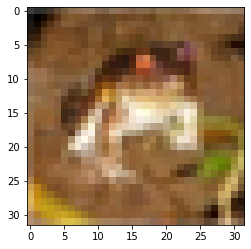

In [ ]:
index = 0
plt.imshow(X_train[index])

# print the sample class by using the classes tuple
print(classes[y_train[index]])

##Dataset preparation

###Data normalization
We normalize data in the range \[0, 1\]

In [ ]:
X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255
X_test = X_test.astype('float32') / 255

###Labels one-hot encoding
We convert the y arrays to "one-hot encoding"

In [ ]:
def one_hot(a, n):
  e = np.eye(n) # Identity matrix n x n
  result=e[a.astype(np.uint8)]
  return result

y_train_1h = one_hot(y_train, num_classes)
y_val_1h = one_hot(y_val, num_classes)
y_test_1h = one_hot(y_test, num_classes)

print('\nBefore one-hot encoding:')
print(y_train[:10])

print('\nAfter one-hot encoding')
print(y_train_1h[:10])


Before one-hot encoding:
[6 9 9 1 1 2 7 8 3 7]

After one-hot encoding
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


#Network architectures

##Training procedure preparation: loss, optimizer and metrics
Now we set the parameters to [compile](https://keras.io/getting-started/sequential-model-guide/#compilation) the model, using the categorical cross-entropy loss function, the SGD optimizer, and the accuracy as additional metric.

In [ ]:
training_params = {
    'optimizer': 'rmsprop',
    'loss': 'categorical_crossentropy',
    'metrics': ['accuracy']
}
# python dictionary contenente i parametri per i layer della rete in modo da inizializzarle allo stesso modo
# Sarebbe possibile anche usare parametri differenti.

##Multi-Layer Perception
Now let us build a Multilayer Perceptron.
To do this, we:

1.   instantiate an empty feed-forward ([Sequential](https://keras.io/api/models/sequential/#sequential-class)) network
2.   add two fully-connected ([Dense](https://keras.io/api/layers/core_layers/dense/)) layers to the network (i.e. one hidden layer and the output layer)

The [sigmoid activation](https://keras.io/api/layers/activations/#sigmoid-function) is used in the hidden layer while the [softmax activation](https://keras.io/api/layers/activations/#softmax-function) is used in the last output layer.


In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# Instantiate an empty Sequential model
MLP = Sequential()

# A hidden layer with sigmoid activation
MLP.add(Dense(180, activation='sigmoid', input_shape=(img_rows * img_cols * img_channels,)))

# A second hidden layer with sigmoid activation
MLP.add(Dense(60, activation='sigmoid', input_shape=(img_rows * img_cols * img_channels,)))

# A output layer with 10 nodes and softmax activation
MLP.add(Dense(num_classes, activation='softmax'))

print(MLP.summary())

MLP.compile(**training_params)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 180)               553140    
                                                                 
 dense_1 (Dense)             (None, 60)                10860     
                                                                 
 dense_2 (Dense)             (None, 10)                610       
                                                                 
Total params: 564,610
Trainable params: 564,610
Non-trainable params: 0
_________________________________________________________________
None


##Convolutional Neural Network
This architecture uses a sequence of:
1. [Convolutional layers](https://keras.io/api/layers/convolution_layers/convolution2d/)
2. [Max Pooling layers](https://keras.io/api/layers/pooling_layers/max_pooling2d/).
3. Finally, the [Flatten layer](https://keras.io/api/layers/reshaping_layers/flatten/) is used to flatten convolutional feature maps before the final fully-connected [Dense](https://keras.io/api/layers/core_layers/dense/) classification stages.

The [ReLU activation](https://keras.io/api/layers/activations/#relu-function) is used for all the layers but the output one, which has the [softmax activation](https://keras.io/api/layers/activations/#softmax-function).

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Instantiate an empty Sequential model
CNN = Sequential()

# CONV2D è un layer di convoluzione per cui devono essere settati una serie di parametri.

# Two consecutive convolutional layers with 3x3 kernels and 32 filters
CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, img_channels)))
CNN.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# Max Pooling layer with 2x2 stride
CNN.add(MaxPooling2D((2, 2)))

# Two consecutive convolutional layers with 3x3 kernels
CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
CNN.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Max Pooling layer with 2x2 stride
CNN.add(MaxPooling2D((2, 2)))

# Two consecutive convolutional layers with 3x3 kernels
CNN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
CNN.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Max Pooling layer with 2x2 stride
CNN.add(MaxPooling2D((2, 2)))

# Flatten out the activation maps
CNN.add(Flatten()) # Flatten l'output del layer precedente cioè lo rende un vettore.
# Final 2 stage fully-connected layers
CNN.add(Dense(128, activation='relu'))
CNN.add(Dense(num_classes, activation='softmax'))

# Model compilation
CNN.summary()

# Compile the model using the pre-defined training parameters
CNN.compile(**training_params)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                    

##Convolutional Neural Network with DropOut

This network also adopts [DropOut layers](https://keras.io/api/layers/regularization_layers/dropout/) to reduce overfitting. Note that DropOut layers do not have trainable parameters.

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Instantiate an empty Sequential model
CNN_DO = Sequential()

# Two consecutive convolutional layers with 3x3 kernels
CNN_DO.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, img_channels)))
CNN_DO.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
# Max Pooling layer with 2x2 stride
CNN_DO.add(MaxPooling2D((2, 2)))



# Two consecutive convolutional layers with 3x3 kernels
CNN_DO.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
CNN_DO.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
# Max Pooling layer with 2x2 stride
CNN_DO.add(MaxPooling2D((2, 2)))
# DropOut layer - NOTE: Parameter is 1-p, not p!
CNN_DO.add(Dropout(0.3))

# Two consecutive convolutional layers with 3x3 kernels
CNN_DO.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
CNN_DO.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
# Max Pooling layer with 2x2 stride
CNN_DO.add(MaxPooling2D((2, 2)))
# DropOut layer - NOTE: Parameter is 1-p, not p!
CNN_DO.add(Dropout(0.4))

# Flatten out the activation maps
CNN_DO.add(Flatten())
# First fully-connected layer
CNN_DO.add(Dense(128, activation='relu'))
# DropOut layer - NOTE: Parameter is 1-p, not p!
CNN_DO.add(Dropout(0.5))
# Second fully-connected layer
CNN_DO.add(Dense(num_classes, activation='softmax'))

# Model compilation
CNN_DO.summary()

# Compile the model using the pre-defined training parameters
CNN_DO.compile(**training_params)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                  

#Training procedure

##Callback functions
Let's define the keras callback functions to log the TensorBoard data, save the best Checkpoint, and perform Early Stopping during training.

In [ ]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint

earlystopping_cb = EarlyStopping(monitor="val_accuracy", patience=20)

tensorboard_mlp_cb = TensorBoard(log_dir='./logs/MLP')
modelcheckpoint_mlp_cb = ModelCheckpoint('./models/MLP', monitor="val_accuracy", save_best_only=True)

tensorboard_cnn_cb = TensorBoard(log_dir='./logs/CNN')
modelcheckpoint_cnn_cb = ModelCheckpoint('./models/CNN', monitor="val_accuracy", save_best_only=True)

tensorboard_cnn_do_cb = TensorBoard(log_dir='./logs/CNN_DO')
modelcheckpoint_cnn_do_cb = ModelCheckpoint('./models/CNN_DO', monitor="val_accuracy", save_best_only=True)


##Training procedure visualization
Now let us use TensorBoard to visualize the training.
In the 'setting' menu set the auto update of the dashboard.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./logs

##Network training

###Train the MLP model
Now we train ([fit](https://keras.io/getting-started/sequential-model-guide/#training)) and save the Multi Layer Perceptron

In [ ]:
# First we remove the './logs/MLP' directory
!rm -rf ./logs/MLP

# Then, we start the training
MLP.fit(X_train.reshape((-1, img_rows * img_cols * img_channels)),
        y_train_1h,
        validation_data=(
            X_val.reshape((-1, img_rows * img_cols * img_channels)),
            y_val_1h,
            ),
        epochs=100,
        batch_size=1024,
        callbacks=[earlystopping_cb, modelcheckpoint_mlp_cb, tensorboard_mlp_cb])

NameError: ignored

###Train the CNN model
Let's train the Convolutional Neural Network

In [ ]:
# First we remove the './logs/CNN' directory
!rm -rf ./logs/CNN

# Then, we start the training
CNN.fit(X_train,
        y_train_1h,
        validation_data=(
            X_val,
            y_val_1h,
            ),
        epochs=100,
        batch_size=1024,
        callbacks=[earlystopping_cb, modelcheckpoint_cnn_cb, tensorboard_cnn_cb])

Epoch 1/100
40/40 [==============================] - 24s 295ms/step - loss: 3.9031 - accuracy: 0.1725 - val_loss: 2.1203 - val_accuracy: 0.2552
Epoch 2/100
40/40 [==============================] - 9s 216ms/step - loss: 2.1135 - accuracy: 0.2436 - val_loss: 2.1198 - val_accuracy: 0.2669
Epoch 3/100
40/40 [==============================] - 8s 213ms/step - loss: 1.9292 - accuracy: 0.3114 - val_loss: 1.9615 - val_accuracy: 0.3188
Epoch 4/100
40/40 [==============================] - 9s 221ms/step - loss: 1.7804 - accuracy: 0.3658 - val_loss: 1.7642 - val_accuracy: 0.3597
Epoch 5/100
40/40 [==============================] - 7s 175ms/step - loss: 1.5982 - accuracy: 0.4352 - val_loss: 1.8072 - val_accuracy: 0.3464
Epoch 6/100
40/40 [==============================] - 8s 213ms/step - loss: 1.4525 - accuracy: 0.4856 - val_loss: 1.2650 - val_accuracy: 0.5580
Epoch 7/100
40/40 [==============================] - 7s 175ms/step - loss: 1.3288 - accuracy: 0.5333 - val_loss: 1.8896 - val_accuracy: 0.355

###Train the CNN model with DropOut layers
Let's train the Convolutional Neural Network with DropOut layers

In [ ]:
# First we remove the './logs/CNN_DO' directory
!rm -rf ./logs/CNN_DO

# Then, we start the training
CNN_DO.fit(X_train,
           y_train_1h,
           validation_data=(
               X_val,
               y_val_1h,
               ),
           epochs=100,
           batch_size=1024,
           callbacks=[earlystopping_cb, modelcheckpoint_cnn_do_cb, tensorboard_cnn_do_cb])

Epoch 1/100
40/40 [==============================] - 12s 256ms/step - loss: 2.2895 - accuracy: 0.1491 - val_loss: 2.1604 - val_accuracy: 0.1977
Epoch 2/100
40/40 [==============================] - 10s 256ms/step - loss: 2.1175 - accuracy: 0.2309 - val_loss: 2.0273 - val_accuracy: 0.2559
Epoch 3/100
40/40 [==============================] - 10s 256ms/step - loss: 1.9868 - accuracy: 0.2785 - val_loss: 1.8410 - val_accuracy: 0.3357
Epoch 4/100
40/40 [==============================] - 10s 246ms/step - loss: 1.8546 - accuracy: 0.3284 - val_loss: 1.6130 - val_accuracy: 0.4221
Epoch 5/100
40/40 [==============================] - 10s 240ms/step - loss: 1.7494 - accuracy: 0.3686 - val_loss: 1.5386 - val_accuracy: 0.4508
Epoch 6/100
40/40 [==============================] - 9s 237ms/step - loss: 1.6547 - accuracy: 0.4060 - val_loss: 1.4391 - val_accuracy: 0.4871
Epoch 7/100
40/40 [==============================] - 10s 263ms/step - loss: 1.5820 - accuracy: 0.4289 - val_loss: 1.4238 - val_accuracy: 

#Inference on the validation set

### Load previously trained models

**Note**: the models are saved with the names 'MLP', 'CNN' and 'CNN_DO'. After a previous run of the training, they were renamed 'MLP_saved', 'CNN_saved' and 'CNN_DO_saved' to prevent their overwriting in subsequent experiments.

In [ ]:
from keras.models import load_model

MLP = load_model('models/MLP_saved')
CNN = load_model('models/CNN_saved')
CNN_DO = load_model('models/CNN_DO_saved')
print('All loaded')

All loaded


##Validation set prediction
We [predict](https://keras.io/api/models/model_training_apis/#predict-method) the labels of validation set samples to compare predictions of different networks.

In [ ]:
y_val_pred_MLP_prob = MLP.predict(X_val.reshape((-1, img_rows * img_cols * img_channels)))
y_val_pred_MLP = y_val_pred_MLP_prob.argmax(1)

y_val_pred_CNN_prob = CNN.predict(X_val)
y_val_pred_CNN = y_val_pred_CNN_prob.argmax(1)

y_val_pred_CNN_DO_prob = CNN_DO.predict(X_val)
y_val_pred_CNN_DO = y_val_pred_CNN_DO_prob.argmax(1)

##Per-class performance evaluation
We define a function to compute and visualize the confusion matrix.
The values are normalized with respect to the total number of samples for each class, separately.

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y, pred, title):
  # MLP confusion matrix
  ConfusionMatrixDisplay.from_predictions(y, pred,
                                          display_labels=np.array(classes),
                                          normalize='true',
                                          values_format='.2f',
                                          xticks_rotation=45
                                          )
  # Visualization commands
  plt.gcf().set_size_inches(10, 10)         # bigger image
  plt.gca().get_images()[0].set_clim(0, 1)  # same color map in the range [0, 1]
  plt.title(title)                          # print the title

Let's visualize the confusion matrices on the validation set for the three networks.

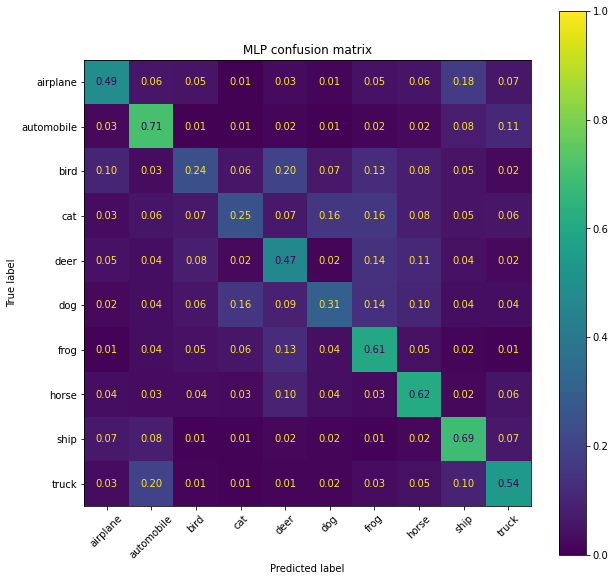

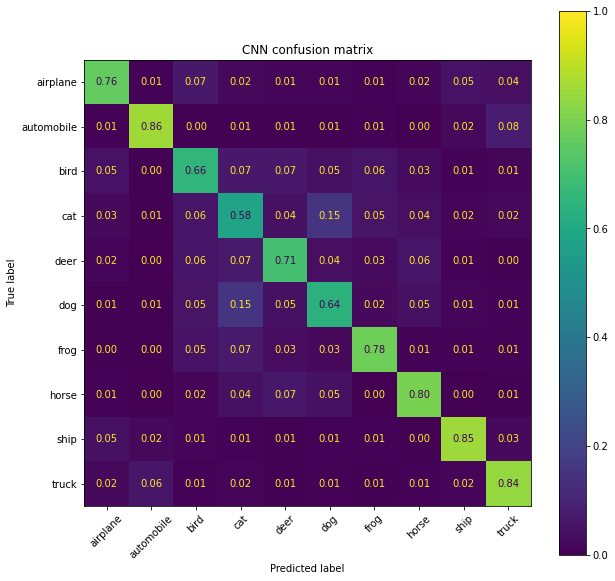

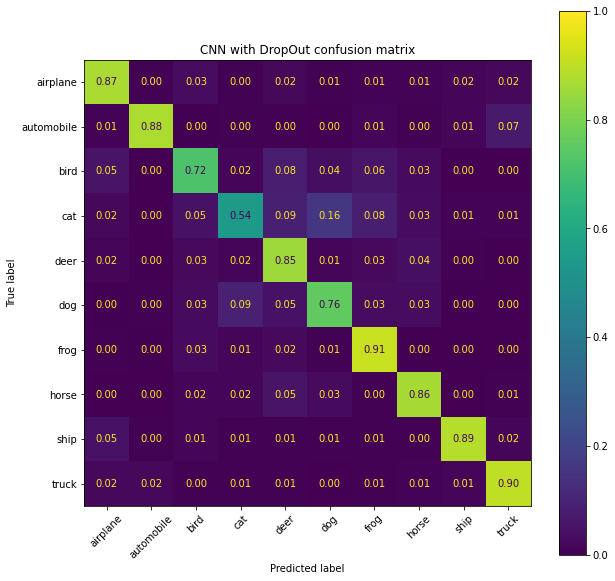

In [ ]:
plot_confusion_matrix(y_val, y_val_pred_MLP, 'MLP confusion matrix')
plot_confusion_matrix(y_val, y_val_pred_CNN, 'CNN confusion matrix')
plot_confusion_matrix(y_val, y_val_pred_CNN_DO, 'CNN with DropOut confusion matrix')

We define a function to print the details of the prediction

In [ ]:
def print_prediction_result(prediction, target):
  '''
  prediction: 1x10 (class number) numpy array of prediction of one sample
  targed: scalar (int) representing the true class of the sample
  '''
  prediction = prediction.squeeze()       # remove trailing dimensions
  predicted = prediction.argmax()         # take the predicted class index
  predicted_name = classes[predicted]     # take the predicted class name using the classes global variable
  predicted_conf = prediction[predicted]  # take the predicted confidence or score

  target_name = classes[target]           # take the true class name
  target_conf = prediction[target]        # take the predicted confidence of the true class

  # print results
  if predicted == target:
    print('Correctly predicted class {} with confidence\t{:.2f}'.format(predicted_name, predicted_conf))
  else:
    print('Error!\n- predicted class\t{}\twith confidence\t{:.2f}\n- correct   class\t{}\thas confidence\t{:.2f}'.format(predicted_name, predicted_conf, target_name, target_conf))


Print the networks' outputs for some validation samples

Target ship

MLP prediction:
Error!
- predicted class	automobile	with confidence	0.34
- correct   class	ship	has confidence	0.34

CNN prediction:
Correctly predicted class ship with confidence	1.00

CNN with Dropout prediction:
Correctly predicted class ship with confidence	1.00


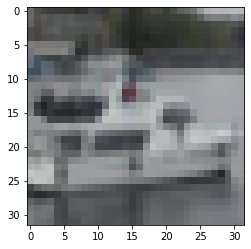

In [ ]:
index = 123
target = y_val[index:index+1].item()
print('Target', classes[target])
plt.imshow(X_val[index])


print('\nMLP prediction:')
print_prediction_result(y_val_pred_MLP_prob[index], target)

print('\nCNN prediction:')
print_prediction_result(y_val_pred_CNN_prob[index], target)

print('\nCNN with Dropout prediction:')
print_prediction_result(y_val_pred_CNN_DO_prob[index], target)

##Hard mining
Show some of the errors of the MLP model that are correctly classified by the CNN model

In [ ]:
# MLP correct decisions:
corr_MLP = np.argwhere(y_val == y_val_pred_MLP).squeeze()

# MLP errors and CNN correct decisions:
err_MLP = np.argwhere(
    np.logical_and(
        y_val != y_val_pred_MLP,
        (y_val == y_val_pred_CNN) | (y_val == y_val_pred_CNN_DO)
        )).squeeze()

# CNN errors and CNN-Dropout correct decisions:
err_CNN = np.argwhere(
    np.logical_and(
        y_val != y_val_pred_CNN,
        y_val == y_val_pred_CNN_DO
        )).squeeze()

# CNN-Dropout errors
err_CNN_DO = np.argwhere(y_val != y_val_pred_CNN_DO).squeeze()

Select one of the index array

In [ ]:
indexes = corr_MLP

In [ ]:
indexes = err_MLP

In [ ]:
indexes = err_CNN

In [ ]:
indexes = err_CNN_DO

Initialize the index.

In [ ]:
i = 0

Visualize sample predictions, then increment the index.

Error!
- predicted class	horse	with confidence	0.28
- correct   class	ship	has confidence	0.14
Error!
- predicted class	truck	with confidence	1.00
- correct   class	ship	has confidence	0.00
Correctly predicted class ship with confidence	0.75


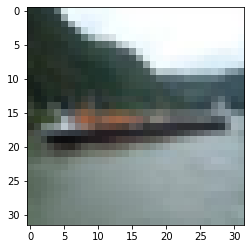

In [ ]:
index = indexes[i]

plt.imshow(X_val[index])

print_prediction_result(y_val_pred_MLP_prob[index], y_val[index])
print_prediction_result(y_val_pred_CNN_prob[index], y_val[index])
print_prediction_result(y_val_pred_CNN_DO_prob[index], y_val[index])

i += 1

# Test set evaluation

##Test set performance computation
Now let us check performance on the test set.

In [ ]:
test_loss_MLP, test_acc_MLP = MLP.evaluate(X_test.reshape((-1, img_rows * img_cols * img_channels)), y_test_1h)
test_loss_CNN, test_acc_CNN = CNN.evaluate(X_test, y_test_1h)
test_loss_CNN_DO, test_acc_CNN_DO = CNN_DO.evaluate(X_test, y_test_1h)

313/313 [==============================] - 3s 9ms/step - loss: 0.6790 - accuracy: 0.8053


##Per-class evaluation
Compute the predictions on the whole test set.

In [ ]:
y_test_pred_MLP = MLP.predict(X_test.reshape((-1, img_rows * img_cols * img_channels))).argmax(1)
y_test_pred_CNN = CNN.predict(X_test).argmax(1)
y_test_pred_CNN_DO = CNN_DO.predict(X_test).argmax(1)

Compute the classification matrices

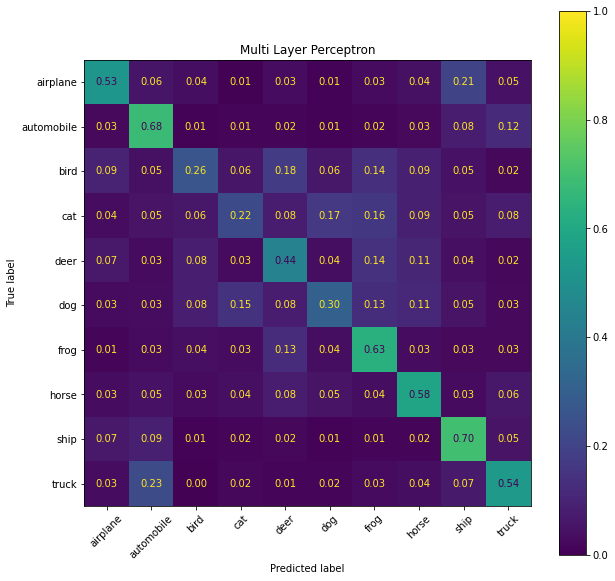

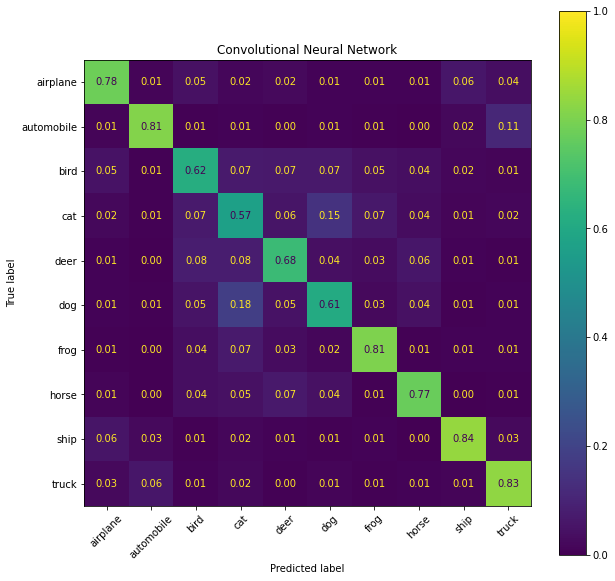

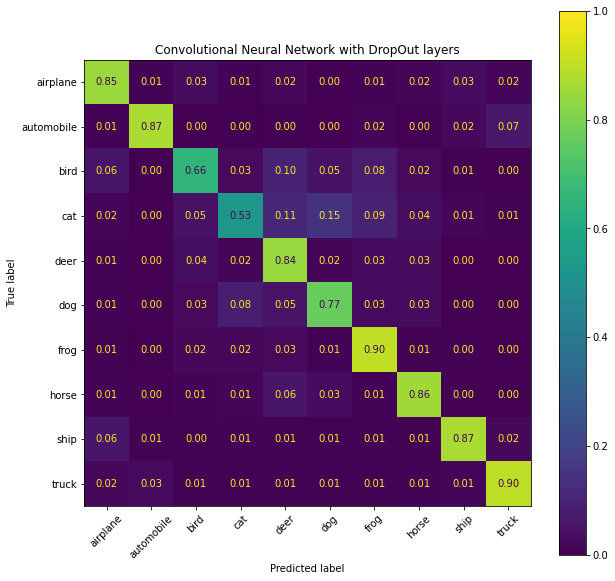

In [ ]:
plot_confusion_matrix(y_test, y_test_pred_MLP, 'Multi Layer Perceptron')
plot_confusion_matrix(y_test, y_test_pred_CNN, 'Convolutional Neural Network')
plot_confusion_matrix(y_test, y_test_pred_CNN_DO, 'Convolutional Neural Network with DropOut layers')

In [ ]:
import sklearn
a = sklearn.preprocessing.OneHotEncoder()
b = a.fit_transform([[0.2,0.5,0.3],[0.2,0.3,0.5]])

In [ ]:
b.data

array([1., 1., 1., 1., 1., 1.])